In [25]:
import gc
import os 
import time 
import numpy as np 
import pandas as pd 

from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, Callback
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.metrics import Precision, Recall, F1Score
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam, SGD
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, LayerNormalization, Activation, GRU, Attention
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import tensorflow as tf

from model.CNN_LSTM.components.engineering import FeatureEngineering
from model.CNN_LSTM.components.dfmodify import DataframeModify 
from model.CNN_LSTM.components.dfcreation import DataframeCreate, DataframeSave
from model.CNN_LSTM.components.custom_keras_callbacks import CustomEarlyStopping

In [2]:
def preprocess_pipeline(timeseries_columns: list, numerical_columns: list, categorical_columns: list = None):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler()) # we should use minmax?
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            # ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def create_graphs(history_dev_1, cm, class_labels):
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set Evaluation')
    plt.ion()
    plt.show()

    # Extracting the history
    train_loss = history_dev_1.history['loss']
    val_loss = history_dev_1.history['val_loss']
    train_acc = history_dev_1.history['accuracy']
    val_acc = history_dev_1.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot training and validation loss
    ax1.plot(epochs, train_loss, label='Train Loss', color='tab:blue')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Plot training and validation accuracy
    ax2.plot(epochs, train_acc, label='Train Accuracy', color='tab:green')
    ax2.plot(epochs, val_acc, label='Validation Accuracy', color='tab:red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Adjust layout to prevent overlap
    fig.tight_layout()

    # Display the plots
    plt.show()

In [3]:
input_path = r"C:\Users\Gen3r\Documents\capstone\ml_model\data\data_3"
dataframe = DataframeCreate.create_dataframe_from_data(input_path=input_path)
X_train, y_train, X_val, y_val, X_test, y_test = DataframeCreate.split_dataset(df=dataframe, target_label='gesture', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
time_series_columns = landmark_columns  # + derived_features   

# augmenting train data
X_train_augmented_1, y_train_augmented_1 = DataframeModify.augment_model(X_train, y_train, noise_level=0.05, translation_vector=[0.6, -0.5, 0.005], rotation_angle=45)
X_train_augmented_2, y_train_augmented_2 = DataframeModify.augment_model(X_train, y_train, noise_level=0.04, translation_vector=[0.2, 0.76, -0.15], rotation_angle=15)
X_train_augmented_3, y_train_augmented_3 = DataframeModify.augment_model(X_train, y_train, noise_level=0.023, translation_vector=[-0.4, 0.3, 0.1], rotation_angle=30)

X_train_precombined = pd.concat([X_train, X_train_augmented_1, X_train_augmented_2, X_train_augmented_3], axis=0, ignore_index=True)
y_train_precombined = pd.concat([y_train, y_train_augmented_1, y_train_augmented_2, y_train_augmented_3], axis=0, ignore_index=True)

X_train_augmented_4, y_train_augmented_4 = DataframeModify.augment_model(X_train_precombined, y_train_precombined, noise_level=0.01, translation_vector=[-0.21, -0.3, -0.01], rotation_angle=-23)

X_train_combined = pd.concat([X_train_precombined, X_train_augmented_4], axis=0, ignore_index=True)
y_train_combined = pd.concat([y_train_precombined, y_train_augmented_4], axis=0, ignore_index=True)

gc.collect()

print("finish augmentation")

X_train_transformed, X_val_transformed, X_test_transformed = None, None, None
Flag = True

if os.path.exists("X_train_transformed.csv.gz") and Flag == True:
    print("loaded from drive")
    X_train_transformed = pd.read_csv("X_train_transformed.csv.gz", compression="gzip")
    X_val_transformed = pd.read_csv("X_val_transformed.csv.gz", compression="gzip")
    X_test_transformed = pd.read_csv("X_test_transformed.csv.gz", compression="gzip")
else:
    print("starting new calculations")
    preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
    X_train_transformed = preprocessor.fit_transform(X_train_combined)
    X_val_transformed = preprocessor.transform(X_val)
    X_test_transformed = preprocessor.transform(X_test)
    DataframeSave.save_dataframe(X_train_transformed, X_val_transformed, X_test_transformed)


print(X_train_transformed.shape, y_train_combined.shape, X_val_transformed.shape, y_val.shape, X_test_transformed.shape, y_test.shape)

# Define sequence length
sequence_length = 30

X_train_sequences, y_train_sequences = DataframeModify.create_sequences_with_labels(X_train_transformed, y_train_combined, sequence_length)
X_val_sequences, y_val_sequences = DataframeModify.create_sequences_with_labels(X_val_transformed, y_val, sequence_length)
X_test_sequences, y_test_sequences = DataframeModify.create_sequences_with_labels(X_test_transformed, y_test, sequence_length)

# Print shapes to verify
print(X_train_sequences.shape)
print(X_val_sequences.shape)
print(X_test_sequences.shape)
print(y_train_combined.shape)
print(y_val.shape)
print(y_test.shape)

class_labels = np.unique(y_test_sequences.tolist())

# Convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_sequences)
y_val_encoded = label_encoder.transform(y_val_sequences)
y_test_encoded = label_encoder.transform(y_test_sequences)

y_train_categorical = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

print(y_train_categorical.shape)
print(y_val_categorical.shape)
print(y_test_categorical.shape)

(55440, 1667) (55440, 1) (6930, 1667) (6930, 1) (6930, 1667) (6930, 1)
duplicated y is set to False
duplicated y is set to False
duplicated y is set to False
duplicated y is set to False
finish augmentation
loaded from drive
(443520, 1667) (443520, 1) (6930, 1667) (6930, 1) (6930, 1667) (6930, 1)
(14784, 30, 1666)
(231, 30, 1666)
(231, 30, 1666)
(443520, 1)
(6930, 1)
(6930, 1)
(14784, 11)
(231, 11)
(231, 11)


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - accuracy: 0.2093 - loss: 2.8898 - val_accuracy: 0.2208 - val_loss: 2.6021 - learning_rate: 1.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.4677 - loss: 2.0295 - val_accuracy: 0.3463 - val_loss: 2.4475 - learning_rate: 1.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.6212 - loss: 1.5947 - val_accuracy: 0.1385 - val_loss: 3.0605 - learning_rate: 1.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.7079 - loss: 1.3303 - val_accuracy: 0.5411 - val_loss: 1.8893 - learning_rate: 1.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7657 - loss: 1.1563 - val_accuracy: 0.7013 - val_loss: 1.3618 - learning_rate: 1.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.7916 - loss: 1.0497 - val_accuracy: 0.6753 - val_loss: 1.5432 - learning_rate: 1.0000e-04
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/

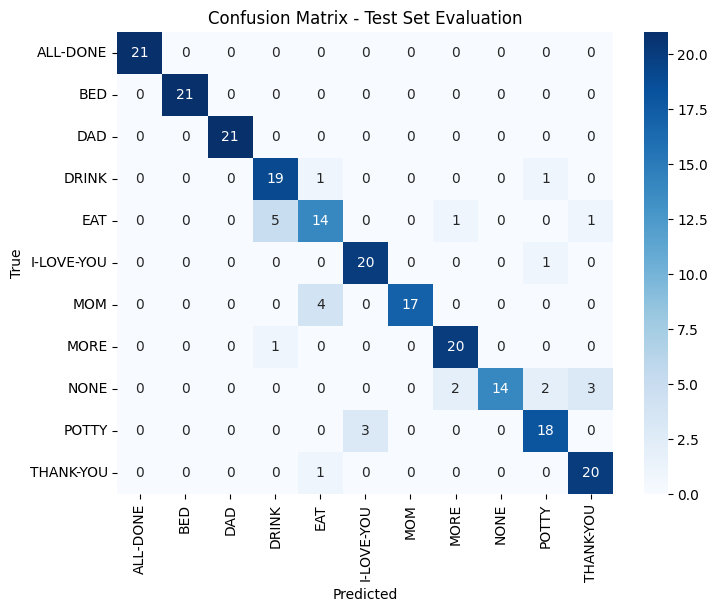

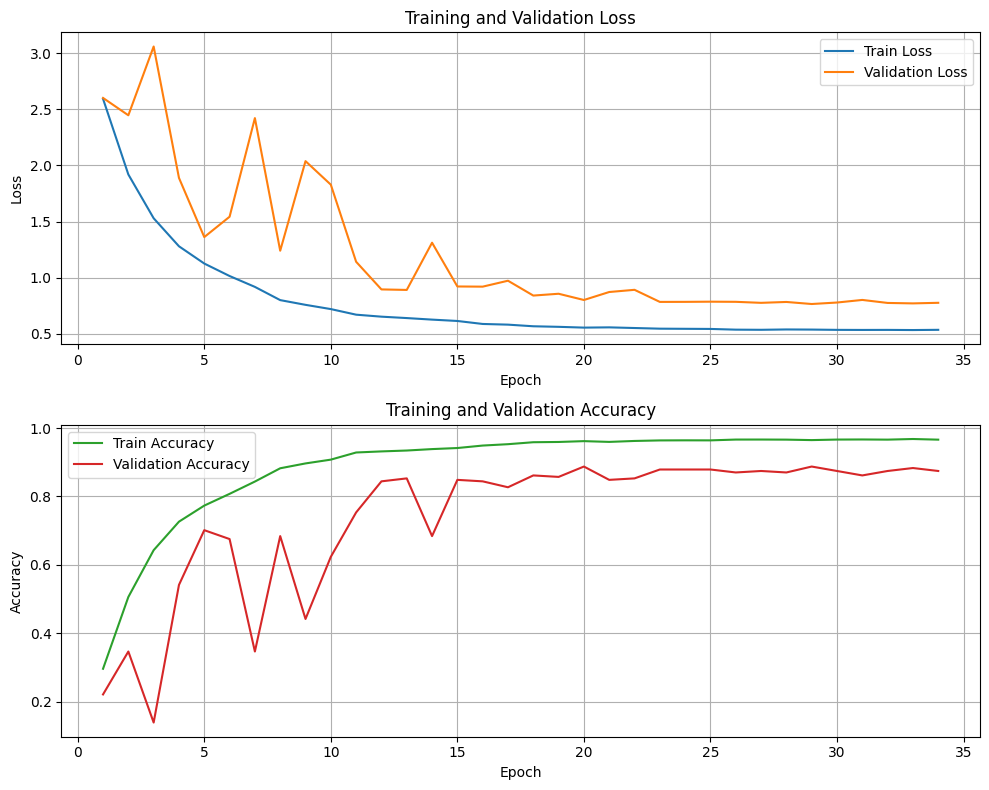

In [63]:
gc.collect()

model = Sequential([
    # NOTE: if we where to just run this as is, we will get an error because of our Y datasets
    # They are a 2D shape, not the 1D it is expecting
    InputLayer(shape=(sequence_length, X_train_sequences.shape[2])),
    
    Conv1D(170, 3, activation="relu6", kernel_regularizer=L1L2(1e-5, 1e-3)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(340, 3, activation="tanh"),
    MaxPooling1D(2),
    Dropout(0.055),

    Conv1D(680, 3, activation="tanh"),
    Dropout(0.1),

    Bidirectional(GRU(128, kernel_regularizer=L2(1e-4))),
    BatchNormalization(),
    Activation("relu6"),
    Dropout(0.5),

    Dense(96),
    BatchNormalization(),

    Dense(64, kernel_regularizer=L2(1e-4)),
    Activation("tanh"),
    Dropout(0.2),

    Dense(len(class_labels), activation='softmax', kernel_regularizer=L1L2(1e-5, 1e-6),  bias_regularizer=L2(1e-5))
])

model.compile(optimizer=Adam(learning_rate=1.0e-4, weight_decay=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.45, patience=2, min_lr=1e-10)	
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
custom_early_stopping = CustomEarlyStopping(patience=15, threshold=0.15)
history = model.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=50,  # Adjust epochs as needed
    batch_size=128,  # Adjust batch size as needed
    callbacks=[reduce_lr, early_stopping]   
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

y_pred = model.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(history, cm, class_labels)

In [28]:
name = f"model_7_v3_{time.time_ns()}"
model.save(f"models/{name}.keras")
model.save_weights(f"models/{name}.weights.h5")

In [9]:
from keras._tf_keras.keras.models import load_model

saved_model = load_model("models/model_5cinq_v31724269896225333500.keras")
test_loss, test_accuracy = model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9419 - loss: 1.0308
Test Loss: 1.0979704856872559
Test Accuracy: 0.9220778942108154


In [ ]:
# k fold training
def build_model():
    model = Sequential([
        # NOTE: if we where to just run this as is, we will get an error because of our Y datasets
        # They are a 2D shape, not the 1D it is expecting
        InputLayer(shape=(sequence_length, X_train_sequences.shape[2])),
        
        GRU(126, kernel_regularizer=L2(1e-5)),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.5),

        Dense(64, kernel_regularizer=L2(1e-5)),
    
        Dense(len(class_labels), activation='softmax', kernel_regularizer=L2(1e-6),  bias_regularizer=L2(1e-5))

    ])

    model.compile(optimizer=Adam(learning_rate=1.0e-4, weight_decay=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    return model 

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1 
histories = []
val_accuracies = []

for train_index, val_index in kf.split(X_train_sequences):
    # Split the data
    X_train_fold, X_val_fold = X_train_sequences[train_index], X_train_sequences[val_index]
    y_train_fold, y_val_fold = y_train_categorical[train_index], y_train_categorical[val_index]

    model = build_model()
    

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.55, patience=2, min_lr=1e-12)	
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)	
    custom_early_stopping = CustomEarlyStopping(patience=5, threshold=0.15)
    history = model.fit(
        X_train_sequences, y_train_categorical,
        validation_data=(X_val_fold, y_val_fold),        
        epochs=50,  # Adjust epochs as needed
        batch_size=128,  # Adjust batch size as needed
        callbacks=[early_stopping, reduce_lr, custom_early_stopping]   
    )

    # Store history and validation accuracy
    histories.append(history)
    val_accuracies.append(max(history.history['val_accuracy']))  
    print(f'Fold {fold_no} - Best Validation Accuracy: {max(history.history["val_accuracy"])}')
    
    fold_no += 1

# After k-fold cross-validation is done
print(f'Mean Validation Accuracy over {kf.get_n_splits()} folds: {np.mean(val_accuracies)}')

Epoch 1/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.1930 - loss: 2.3758 - val_accuracy: 0.3420 - val_loss: 1.7939 - learning_rate: 1.0000e-04
Epoch 2/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4176 - loss: 1.6918 - val_accuracy: 0.4372 - val_loss: 1.7170 - learning_rate: 1.0000e-04
Epoch 3/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5080 - loss: 1.3868 - val_accuracy: 0.4719 - val_loss: 1.5864 - learning_rate: 1.0000e-04
Epoch 4/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5917 - loss: 1.1434 - val_accuracy: 0.6147 - val_loss: 1.0619 - learning_rate: 1.0000e-04
Epoch 5/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.6429 - loss: 1.0051 - val_accuracy: 0.4545 - val_loss: 1.9676 - learning_rate: 1.0000e-04
Epoch 6/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.6891 - loss: 0.8737 - val_accuracy: 0.6017 - val_loss: 1.0915 - learning_rate: 1.0000e-04
Epoch 7/50
462/462 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/ste

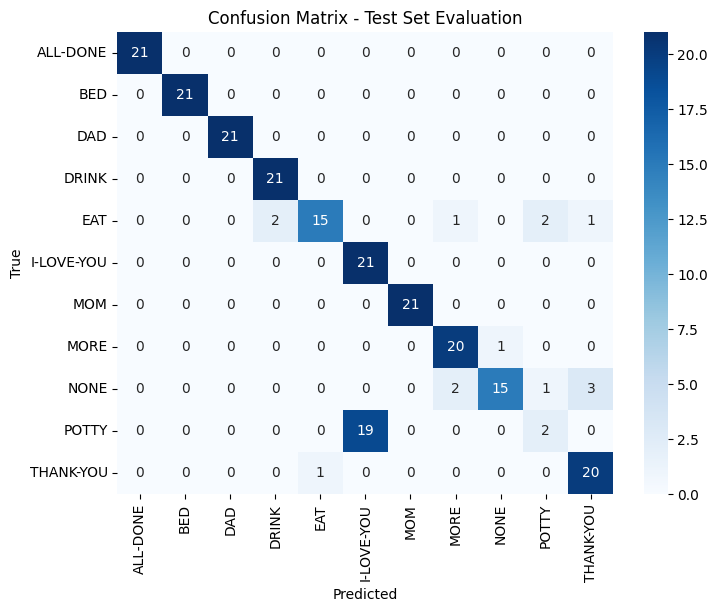

AttributeError: 'dict' object has no attribute 'history'

In [6]:
# keras bagging

from keras._tf_keras.keras.models import clone_model 
import tensorflow as tf
model_test = Sequential([
    # NOTE: if we where to just run this as is, we will get an error because of our Y datasets
    # They are a 2D shape, not the 1D it is expecting
    InputLayer(shape=(sequence_length, X_train_sequences.shape[2])),
    
    Conv1D(164, 4, activation="relu6"),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.01),

    GRU(128, kernel_regularizer=L2(1e-5)),
    BatchNormalization(),
    Activation("leaky_relu"),
    Dropout(0.5),


    Dense(64, kernel_regularizer=L2(1e-5)),
    Activation("tanh"),
    Dropout(0.165),

    Dense(len(class_labels), activation='softmax', kernel_regularizer=L2(1e-6),  bias_regularizer=L2(1e-5))
])

# Initialize lists to store the averaged history
avg_accuracy = np.zeros((50,))
avg_val_accuracy = np.zeros((50,))
avg_loss = np.zeros((50,))
avg_val_loss = np.zeros((50,))

n_models = 5
models = []
predictions = []

dataset = tf.data.Dataset.from_tensor_slices((X_train_sequences, y_train_categorical))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.55, patience=2, min_lr=1e-12)	
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)	
custom_early_stopping = CustomEarlyStopping(patience=10, threshold=0.15)
for i in range(n_models):
    # clone og model 
    model_clone = clone_model(model_test)
    model_clone.compile(optimizer=Adam(learning_rate=1.0e-4, weight_decay=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

    # create boostrap sample 
    dataset_bootstrap = dataset.shuffle(buffer_size=len(X_train)).batch(len(X_train)).take(1)
    for X_bootstrap, Y_bootstrap in dataset_bootstrap:
        # Train the cloned model
        history = model_clone.fit(X_bootstrap, Y_bootstrap, epochs=50, validation_data=(X_val_sequences, y_val_categorical), callbacks=[reduce_lr])
        models.append(model_clone)

    # Sum the metrics across epochs for averaging later
    avg_accuracy += np.array(history.history['accuracy'])
    avg_val_accuracy += np.array(history.history['val_accuracy'])
    avg_loss += np.array(history.history['loss'])
    avg_val_loss += np.array(history.history['val_loss'])

# make predictions on the test sets and average them 
for model in models:
    predictions.append(model.predict(X_test_sequences))

# Divide by the number of models to get the average
avg_accuracy /= n_models
avg_val_accuracy /= n_models
avg_loss /= n_models
avg_val_loss /= n_models

# Create a dictionary to mock a history object
averaged_history = {
    'accuracy': avg_accuracy,
    'val_accuracy': avg_val_accuracy,
    'loss': avg_loss,
    'val_loss': avg_val_loss
}

# Averaging the predictions
final_predictions = np.mean(predictions, axis=0)


y_pred_labels = np.argmax(final_predictions, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

# Generate confusion matrix
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(averaged_history, cm, class_labels)

Trial 5 Complete [00h 09m 22s]
val_accuracy: 0.30519479513168335

Best val_accuracy So Far: 0.3246753364801407
Total elapsed time: 00h 48m 59s


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 71 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 58s 333ms/step - accuracy: 0.3722 - loss: 2.1971 - val_accuracy: 0.2944 - val_loss: 2.3757 - learning_rate: 1.0000e-05
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 307ms/step - accuracy: 0.3906 - loss: 2.1344 - val_accuracy: 0.2684 - val_loss: 2.2832 - learning_rate: 1.0000e-05
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 314ms/step - accuracy: 0.3995 - loss: 2.0873 - val_accuracy: 0.2771 - val_loss: 2.3534 - learning_rate: 1.0000e-05
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 37s 317ms/step - accuracy: 0.4134 - loss: 2.0583 - val_accuracy: 0.2987 - val_loss: 2.2970 - learning_rate: 1.0000e-05
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 36s 313ms/step - accuracy: 0.4423 - loss: 2.0068 - val_accuracy: 0.2987 - val_loss: 2.3395 - learning_rate: 7.5000e-06
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.1828 - loss: 2.3924
Test Loss: 2.3098883628845215
Test Accuracy: 0.2554112672805786
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


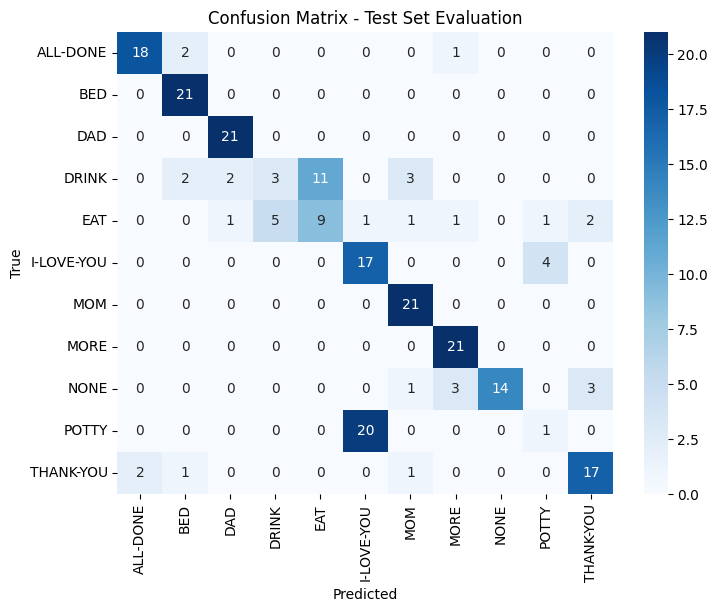

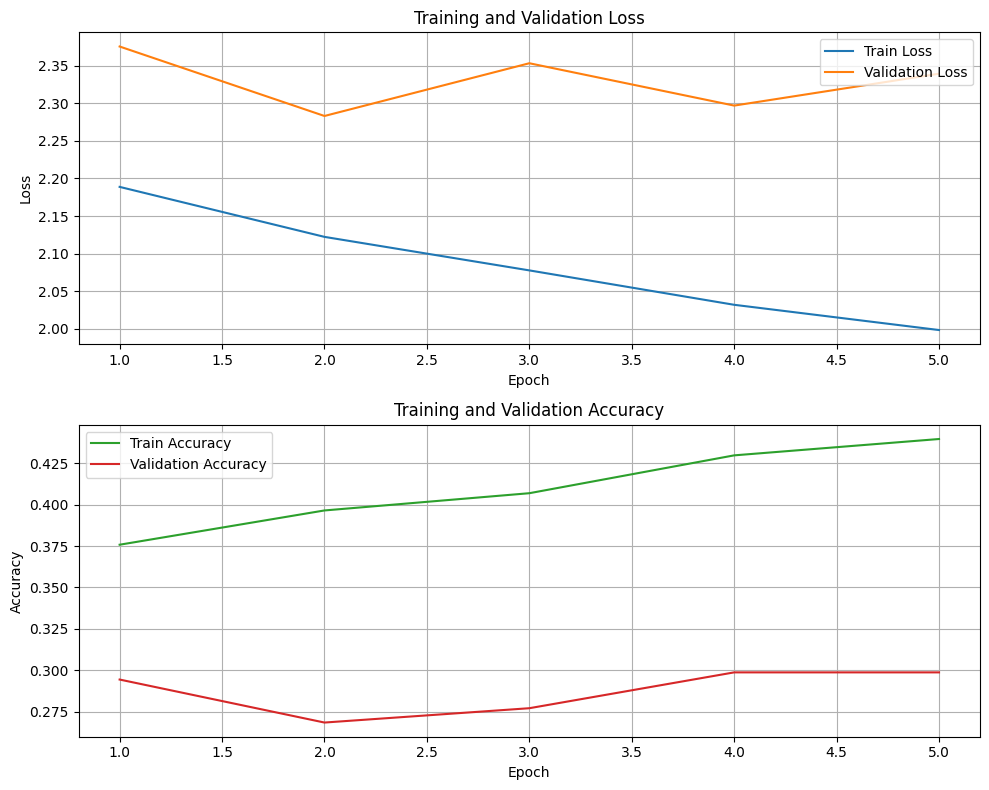

In [ ]:
# keras tuner
import keras_tuner as kt 
from keras_tuner.tuners import BayesianOptimization, Hyperband
activation_list = ["relu", "leaky_relu", "tanh", "relu6"]

def build_model(hp: kt.HyperParameters):
    use_regularizer_1 = hp.Boolean("use_regularizer_1")
    if use_regularizer_1:
        regularizer_1 = L1L2(hp.Float("l1_1", min_value=1e-6, max_value=1e-3, sampling="log"), hp.Float("l2_1", min_value=1e-6, max_value=1e-3, sampling="log"))
    else:
        regularizer_1 = None

    use_regularizer_4 = hp.Boolean("use_regularizer_4")
    if use_regularizer_4:
        regularizer_type = hp.Choice("regularizer_type", values=["L1L2", "L2"])
        if regularizer_type == "L1L2":
            regularizer_4 = L1L2(hp.Float("l1_4", min_value=1e-6, max_value=1e-3, sampling="log"), hp.Float("l2_4", min_value=1e-6, max_value=1e-3, sampling="log"))
        else:
            regularizer_4 = L2( hp.Float("l2_4_2", min_value=1e-6, max_value=1e-3, sampling="log"))
    else:
        regularizer_4 = None

    model = Sequential([
        # NOTE: if we where to just run this as is, we will get an error because of our Y datasets
        # They are a 2D shape, not the 1D it is expecting
        InputLayer(shape=(sequence_length, 1666)),
        
        Conv1D(filters=hp.Int("units_1", min_value=1, max_value=512), kernel_size= hp.Int("k_size_1", 1, 3), activation=hp.Choice("activation_1", activation_list),
           kernel_regularizer=regularizer_1),
        Activation(activation=hp.Choice("activation_1", activation_list)),
        BatchNormalization(),
        MaxPooling1D(pool_size=hp.Int("p_size_1", min_value=1, max_value=2)),
        Dropout(hp.Float("drop_1", min_value=0.01, max_value=0.9)),

        Conv1D(filters=hp.Int("units_2", min_value=1, max_value=512), kernel_size=hp.Int("k_size_2", 1, 3), activation=hp.Choice("activation_2", activation_list)),
        LayerNormalization(),
        Activation(activation=hp.Choice("activation_2", activation_list)),
        MaxPooling1D(pool_size=hp.Int("p_size_2", min_value=1, max_value=2)),
        BatchNormalization(),

        Conv1D(filters=hp.Int("units_3", min_value=1, max_value=512), kernel_size=hp.Int("k_size_4", 1, 3)),
        Activation(activation=hp.Choice("activation_3", activation_list)),
        MaxPooling1D(pool_size=hp.Int("p_size_3", min_value=1, max_value=2)),

        Bidirectional(GRU(units=hp.Int("units7", min_value=24, max_value=512, step=32), return_sequences=True, kernel_regularizer=regularizer_4)),
        LayerNormalization(),
        Activation(activation=hp.Choice("activation_4", activation_list)),
        Dropout(hp.Float("drop_4", min_value=0.01, max_value=0.9)),
        
        GlobalMaxPooling1D(),
        
        Dense(hp.Int("units_5", min_value=1, max_value=1024), kernel_regularizer=L2(hp.Float("l2_5", min_value=1e-6, max_value=1e-3, sampling="log"))),
        BatchNormalization(),
        Activation(activation=hp.Choice("activation_5", activation_list)),
        Dropout(hp.Float("drop_5", min_value=0.01, max_value=0.9)),

        Dense(hp.Int("units_6", min_value=1, max_value=1024), kernel_regularizer=L2(hp.Float("l2_6", min_value=1e-6, max_value=1e-3, sampling="log"))),
        BatchNormalization(),

        Dense(hp.Int("units_7", min_value=12, max_value=1024), kernel_regularizer=L2(hp.Float("l2_7", min_value=1e-6, max_value=1e-3, sampling="log"))),
        BatchNormalization(),
        Activation(activation=hp.Choice("activation_7", activation_list)),
        Dropout(hp.Float("drop_7", min_value=0.01, max_value=0.9)),

        Activation(activation=hp.Choice("activation_8", activation_list)),
        Dropout(hp.Float("drop_8", min_value=0.01, max_value=0.9)),
        Dense(len(class_labels), activation='softmax', kernel_regularizer=L2(hp.Float("l2_8", min_value=1e-6, max_value=1e-3, sampling="log")))
    ])

    model.compile(optimizer=Nadam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5]), weight_decay=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    hypermodel=build_model,  # Your model-building function
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory="results_dir",
    project_name="cnn_rnn",
    overwrite=True,
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-12)	
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)	
custom_early_stopping = CustomEarlyStopping(patience=5, threshold=0.15)
tuner.search(X_train_sequences, y_train_categorical, epochs=25, validation_data=(X_val_sequences, y_val_categorical), callbacks=[early_stopping, reduce_lr, custom_early_stopping], batch_size=64)
best_model = tuner.get_best_models()[0]

history = best_model.fit(
    X_train_sequences, y_train_categorical,
    validation_data=(X_val_sequences, y_val_categorical),
    epochs=50,  # Adjust epochs as needed
    batch_size=64,  # Adjust batch size as needed
    callbacks=[early_stopping, reduce_lr, custom_early_stopping]   
)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test_sequences, y_test_categorical)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

y_pred = model.predict(X_test_sequences)
y_test_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
create_graphs(history, cm, class_labels)